# Marubeni Corporation Data Challenge

Siinn Che

## Introduction

Flight delay and cancelation is one of the major problems that airlines are facing with. Our client, American Airline wants to investigate the flight delay and cancelation in order to understand potential causes of flight delays and their effects on public perception on its brand.

In this data challege, I will
- perform exploratory data analysis
- determine cause of flight delay
- investigate public perception on American Airline in regards to flight delays

The dataset is obtained from the Kaggle competition
https://www.kaggle.com/usdot/flight-delays

Also, additional data is acquired from the following sources. 

Twitter sentiment data:
- https://www.kaggle.com/crowdflower/twitter-airline-sentiment

Aircraft registration data:
- https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download/

### Import libraries

In [1]:
import datetime
import itertools
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import warnings
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('chained_assignment',None)

In [2]:
# set style sheet
plt.style.use("ggplot")
sns.set_style("whitegrid")

In [3]:
# import data
df_raw = pd.read_csv('flight-delays/flights.csv', low_memory=False)

In [4]:
df_airline = pd.read_csv('flight-delays/airlines.csv', low_memory=False)
df_airports = pd.read_csv('flight-delays/airports.csv', low_memory=False)

In [5]:
df_raw.head(3)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [433]:
### select small subset for testing
df = df_raw.sample(frac=0.3)

## Data Cleaning
Before we perform an exploratory analysis, I examined the data. The data is nicely structured with no obvious missing value. So in this section, I performed the following transformation.

- I converted dates given in three columns, "YEAR", "MONTH", "DATE" into a single datetime object.
- Cleaned differet data types (str, float)
- Impute missing values (delay time, reason for on-time flights)
- Retrieved full airport name
- Created boolean features representing flight delay

In [434]:
# combine three columsn into one datetime object
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [435]:
# select features of interest
df = df[[
            "DATE",
            "MONTH",
            "DAY_OF_WEEK",
            "SCHEDULED_DEPARTURE",
            "SCHEDULED_ARRIVAL",
            "SCHEDULED_TIME",
            "AIRLINE",
            "FLIGHT_NUMBER",
            "TAIL_NUMBER",
            "ORIGIN_AIRPORT",
            "DESTINATION_AIRPORT",
            "DEPARTURE_DELAY",
            "ARRIVAL_DELAY",
            "TAXI_OUT",
            "AIR_TIME",
            "TAXI_IN",
            "ELAPSED_TIME",
            "DIVERTED",
            "CANCELLED",
            "CANCELLATION_REASON",
            "AIRLINE_DELAY",
            "LATE_AIRCRAFT_DELAY",
            "WEATHER_DELAY",
            "AIR_SYSTEM_DELAY",
            "SECURITY_DELAY"
            ]]
print(df.head())
print(df.info())

              DATE  MONTH  DAY_OF_WEEK  SCHEDULED_DEPARTURE  \
3082435 2015-07-12      7            7                 1801   
591653  2015-02-09      2            1                  800   
3885222 2015-08-29      8            6                 1715   
5647325 2015-12-20     12            7                 1850   
2917150 2015-07-02      7            4                 1521   

         SCHEDULED_ARRIVAL  SCHEDULED_TIME AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
3082435               1919            78.0      MQ           3425      N645MQ   
591653                 837            37.0      HA            116      N486HA   
3885222               2029           134.0      DL             30      N915DE   
5647325               2038           168.0      EV           5005      N615QX   
2917150               1658           157.0      UA           1592      N33262   

        ORIGIN_AIRPORT      ...       TAXI_IN  ELAPSED_TIME  DIVERTED  \
3082435            BPT      ...          25.0          85.0  

### Creating Boolean features representing delays
Here, I create boolean features for each cause of delay. i.e. if a flight is delayed by weather, "WEATHER_DELAY_BOOL" is 1. If the same flight is delayed by other reason, "WEATHER_DELAY_BOOL" would be 0.

In [436]:
# This function will return True if value is > 0
# It will return False if value is None or 0.
def FillNAorZero(x):
    
    if x > 0:
        return True
    else:
        return False

In [437]:
# create binary columns 
df.loc[:,"AIRLINE_DELAY_BOOL"]       = df["AIRLINE_DELAY"].apply(FillNAorZero)
df.loc[:,"LATE_AIRCRAFT_DELAY_BOOL"] = df["LATE_AIRCRAFT_DELAY"].apply(FillNAorZero)
df.loc[:,"WEATHER_DELAY_BOOL"]       = df["WEATHER_DELAY"].apply(FillNAorZero)
df.loc[:,"AIR_SYSTEM_DELAY_BOOL"]    = df["AIR_SYSTEM_DELAY"].apply(FillNAorZero)
df.loc[:,"SECURITY_DELAY_BOOL"]      = df["SECURITY_DELAY"].apply(FillNAorZero)

### Missing values
Again, there was no obvious missing values, but when flight is not delayed the features representing delay time and reasons are not filled. Because I wanted to use them as categorical values in integers, I assigned 0 for those empty values.

In [438]:
# we will use LabelEncoder to convert categorical values to integers
le = LabelEncoder()

#### Filling missing values in "Cancellation reason"

In [439]:
# fill Nan with label so that we can convert the column into categorical integers
df.loc[:,"CANCELLATION_REASON"] = df["CANCELLATION_REASON"].fillna("E")

# categorize values into integer
df.loc[:,"CANCELLATION_REASON_INT"] = le.fit_transform(df["CANCELLATION_REASON"])

#### Filling missing values in delay times such as "Airline delay"

In [440]:
# fill Nan with label so that we can convert the column into categorical integers
df.loc[:,"AIRLINE_DELAY"]       = df["AIRLINE_DELAY"].fillna(0.0)
df.loc[:,"LATE_AIRCRAFT_DELAY"] = df["LATE_AIRCRAFT_DELAY"].fillna(0.0)
df.loc[:,"WEATHER_DELAY"]       = df["WEATHER_DELAY"].fillna(0.0)
df.loc[:,"AIR_SYSTEM_DELAY"]    = df["AIR_SYSTEM_DELAY"].fillna(0.0)
df.loc[:,"SECURITY_DELAY"]      = df["SECURITY_DELAY"].fillna(0.0)

#### Create columns representing final label of arrival/departure delay

In [441]:
# create boolean columns
df["ARRIVAL_DELAY_BOOL"] = df["ARRIVAL_DELAY"] > 0
df["DEPARTURE_DELAY_BOOL"] = df["DEPARTURE_DELAY"] > 0

In [442]:
df["ARRIVAL_DELAY_BOOL"] = le.fit_transform(df["ARRIVAL_DELAY_BOOL"])
df["DEPARTURE_DELAY_BOOL"] = le.fit_transform(df["DEPARTURE_DELAY_BOOL"])

#### Retrieve full airline and airport name

In [443]:
# create dictionary of IATA code : airline names
airline_dict = df_airline.set_index('IATA_CODE')['AIRLINE'].to_dict()

# Add a column with airline full name
df["AIRLINE_full"] = df["AIRLINE"].replace(airline_dict)

In [444]:
# create dictionary of IATA code : airline names
airports_dict = df_airports.set_index('IATA_CODE')['AIRPORT'].to_dict()

# Add a column with airline full name
df["DESTINATION_AIRPORT_full"] = df["DESTINATION_AIRPORT"].replace(airports_dict)
df["ORIGIN_AIRPORT_full"]      = df["ORIGIN_AIRPORT"].replace(airports_dict)

### Calculating bumper between flights

After doing research, I have learned that the main cause of flight delay is actually short bumper time between each flight. In other words, airlines can reduce flight delay by increasing the bumper between each flight.

Therefore, I calculated the time between an aircraft arrival and the next flight to be used as a feature for a machine learning model.

The below functions are taken from
https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

In [18]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [19]:
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [20]:
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [21]:
# convert scheduled departure into datetime
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')

In [22]:
# add scheduled time to departure time to get scheduled arrival
df["SCHEDULED_TIME"]= pd.to_timedelta(df['SCHEDULED_TIME'],'m')
df["SCHEDULED_ARRIVAL"] = df["SCHEDULED_DEPARTURE"] + df["SCHEDULED_TIME"] 

In [23]:
# calculate padding time
df_g = df.groupby("TAIL_NUMBER").apply(lambda row: row['SCHEDULED_DEPARTURE'] - row.shift(1)['SCHEDULED_ARRIVAL']).reset_index()
df = df.reset_index()
df = df.join(df_g.set_index('level_1'), on='index', rsuffix="grouped")

In [24]:
# cleaning padding time
df.columns = [                   'index',                     'DATE',
                          'MONTH',              'DAY_OF_WEEK',
            'SCHEDULED_DEPARTURE',        'SCHEDULED_ARRIVAL',
                 'SCHEDULED_TIME',                  'AIRLINE',
                  'FLIGHT_NUMBER',              'TAIL_NUMBER',
                 'ORIGIN_AIRPORT',      'DESTINATION_AIRPORT',
                'DEPARTURE_DELAY',            'ARRIVAL_DELAY',
                       'TAXI_OUT',                 'AIR_TIME',
                        'TAXI_IN',             'ELAPSED_TIME',
                       'DIVERTED',                'CANCELLED',
            'CANCELLATION_REASON',            'AIRLINE_DELAY',
            'LATE_AIRCRAFT_DELAY',            'WEATHER_DELAY',
               'AIR_SYSTEM_DELAY',           'SECURITY_DELAY',
             'AIRLINE_DELAY_BOOL', 'LATE_AIRCRAFT_DELAY_BOOL',
             'WEATHER_DELAY_BOOL',    'AIR_SYSTEM_DELAY_BOOL',
            'SECURITY_DELAY_BOOL',  'CANCELLATION_REASON_INT',
             'ARRIVAL_DELAY_BOOL',     'DEPARTURE_DELAY_BOOL',
                   'AIRLINE_full', 'DESTINATION_AIRPORT_full',
            'ORIGIN_AIRPORT_full',       'TAIL_NUMBERgrouped',
                                'PADDING_TIME']

In [25]:
def clean_padding_time(df):
    t=df['PADDING_TIME']
    try:
        t = t.total_seconds() / 60
        return t
    except ValueError:
        return 60 * 24

In [26]:
# convert padding time in TimeDelta to minutes
df['PADDING_TIME'] = df.apply(clean_padding_time,axis=1)

# if padding time is not available, replace it with 1 day
df["PADDING_TIME"] = df["PADDING_TIME"].fillna(24*60)

### Aircraft Features
At the end of the data challenge, I have learned that the most importact feature in predicting flight delays is tail number which is a unique registration assigned for each aircraft. So I obtained additional data on aircraft from,
https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download/

This dataset contains information about aircrafts such as
- Aircraft model
- Engine model
- Manufactured year
- Expiration date, etc.

In [28]:
# import aircraft database
df_a = pd.read_csv("ReleasableAircraft/MASTER.txt", low_memory=False)
df_a.columns

Index(['N-NUMBER', 'SERIAL NUMBER', 'MFR MDL CODE', 'ENG MFR MDL', 'YEAR MFR',
       'TYPE REGISTRANT', 'NAME', 'STREET', 'STREET2', 'CITY', 'STATE',
       'ZIP CODE', 'REGION', 'COUNTY', 'COUNTRY', 'LAST ACTION DATE',
       'CERT ISSUE DATE', 'CERTIFICATION', 'TYPE AIRCRAFT', 'TYPE ENGINE',
       'STATUS CODE', 'MODE S CODE', 'FRACT OWNER', 'AIR WORTH DATE',
       'OTHER NAMES(1)', 'OTHER NAMES(2)', 'OTHER NAMES(3)', 'OTHER NAMES(4)',
       'OTHER NAMES(5)', 'EXPIRATION DATE', 'UNIQUE ID', 'KIT MFR',
       ' KIT MODEL', 'MODE S CODE HEX', 'Unnamed: 34'],
      dtype='object')

In [29]:
# select features of interest
df_a = df_a[["N-NUMBER", "YEAR MFR", "MFR MDL CODE", "EXPIRATION DATE", "TYPE ENGINE", "TYPE AIRCRAFT"]]

In [30]:
def convert_tail_number(x):
    if type(x) != str:
        return x
    else:
        return str(x)[1:]
    
def clean_expiration_date(x):
    
    # remove dates
    if len(str(x)) > 4:
        return str(x)[:-4]
    # otherwise return x
    else:
        return x

In [31]:
# convert TAIL_NUMBER to correct format so that we can join with N-NUMBER
df["N-NUMBER"] = df["TAIL_NUMBER"].apply(convert_tail_number)

# join two dataframe using N-Number
df = df.join(df_a.set_index('N-NUMBER'), on='N-NUMBER', rsuffix="AIRCRAFT")

In [473]:
df_a.head(3)

,N-NUMBER,YEAR MFR,MFR MDL CODE,EXPIRATION DATE,TYPE ENGINE,TYPE AIRCRAFT
0,1,1988,3980115,20191130,5,5
1,100,1940,7100510,20200430,1,4
2,10001,1928,9601202,20190630,1,4


Now, let's clean the aircraft features so that they are suitable for building model
- Manufactured and expiration date: only year is kept
- Aircraft model and engine models are converted into categorical features

Let's impute some missing values.

In [33]:
# calculate average value
year_mfr = df.loc[(~df["YEAR MFR"].isnull()) & (df["YEAR MFR"] !='    ')]["YEAR MFR"][:1000].apply(lambda x: float(x)).mean()

# fill null with average manufactured year
df["YEAR MFR"] = df["YEAR MFR"].fillna(year_mfr)
df["YEAR MFR"] = df["YEAR MFR"].apply(lambda x: year_mfr if x == '    ' else float(x))

In [34]:
# initial clean
df["EXPIRATION DATE"] = df["EXPIRATION DATE"].apply(clean_expiration_date)

# calculate average value
exp_date = df.loc[(~df["EXPIRATION DATE"].isnull()) & (df["EXPIRATION DATE"] !='    ')]["EXPIRATION DATE"][:1000].apply(lambda x: float(x)).mean()

# fill with the average value
df["EXPIRATION DATE"] = df["EXPIRATION DATE"].fillna(exp_date)
df["EXPIRATION DATE"] = df["EXPIRATION DATE"].apply(lambda x: year_mfr if x == '    ' else float(x))

In [35]:
# inpute model code
df["MFR MDL CODE"]  = df["MFR MDL CODE"].fillna(0)
df["MFR MDL CODE"] = df["MFR MDL CODE"].apply(lambda x: str(x))
df["MFR MDL CODE"] = le.fit_transform(df["MFR MDL CODE"])

# inpute engine type
df["TYPE ENGINE"]  = df["TYPE ENGINE"].fillna(0)
df["TYPE ENGINE"] = df["TYPE ENGINE"].apply(lambda x: str(x))
df["TYPE ENGINE"] = le.fit_transform(df["TYPE ENGINE"])

# inpute engine type
df["TYPE AIRCRAFT"]  = df["TYPE AIRCRAFT"].fillna(0)
df["TYPE AIRCRAFT"] = df["TYPE AIRCRAFT"].apply(lambda x: str(x))
df["TYPE AIRCRAFT"] = le.fit_transform(df["TYPE AIRCRAFT"])

### Summary of data cleaning

Here is the dataframe after data cleaning. We only kept features of interest, and delay times are formatted in minutes. We also created boolean features for each cause of delay.

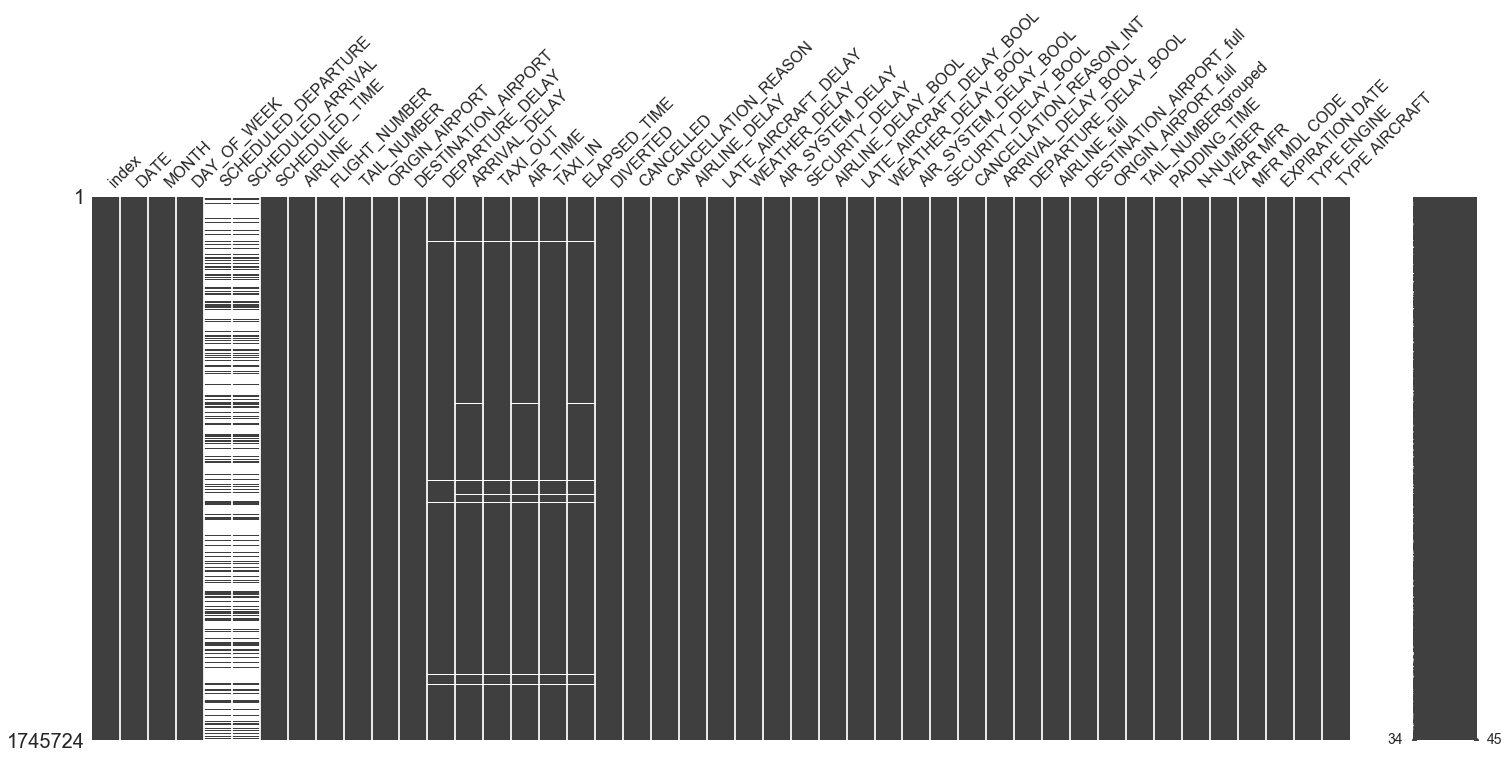

In [36]:
# visualize missing values
msno.matrix(df)

In [449]:
df.head(3)

,DATE,MONTH,DAY_OF_WEEK,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,...,LATE_AIRCRAFT_DELAY_BOOL,WEATHER_DELAY_BOOL,AIR_SYSTEM_DELAY_BOOL,SECURITY_DELAY_BOOL,CANCELLATION_REASON_INT,ARRIVAL_DELAY_BOOL,DEPARTURE_DELAY_BOOL,AIRLINE_full,DESTINATION_AIRPORT_full,ORIGIN_AIRPORT_full
3082435,2015-07-12,7,7,1801,1919,78.0,MQ,3425,N645MQ,BPT,...,False,False,False,False,4,1,1,American Eagle Airlines Inc.,Dallas/Fort Worth International Airport,Jack Brooks Regional Airport (Southeast Texas ...
591653,2015-02-09,2,1,800,837,37.0,HA,116,N486HA,HNL,...,False,False,False,False,4,0,0,Hawaiian Airlines Inc.,Kahului Airport,Honolulu International Airport
3885222,2015-08-29,8,6,1715,2029,134.0,DL,30,N915DE,DFW,...,False,False,False,False,4,0,0,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Dallas/Fort Worth International Airport


## Exploratory Analysis

### Investigating each feature
As a first step, I first  examined each features individually, and I will look at its distribution. This will allow us to understand the features, and it will also help us to find any outliers or wrong values.

#### Discrete feature distribution

In [38]:
# names of features with categorical values
features_cat = ['AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT']

# names of features with continuous values
features_continuous = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT',
       'AIR_TIME', 'TAXI_IN', 'ELAPSED_TIME']

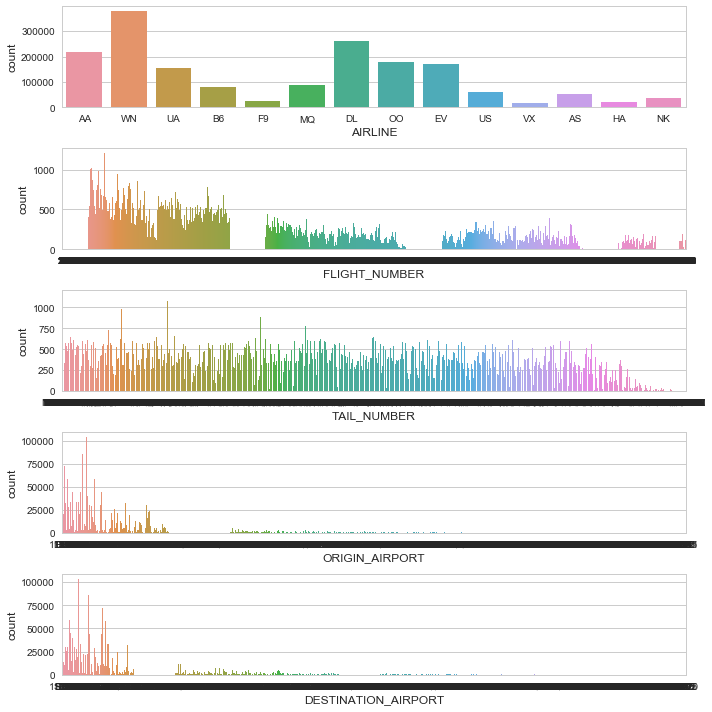

In [39]:
# create figure and axes
fig, ax = plt.subplots(5,1, figsize=(10,10))

# loop over each feature names to create distributions
for i, feature in enumerate(features_cat):
    sns.countplot(x = feature, data=df, ax=ax[i])
    
# use tight layout    
plt.tight_layout()

Observation from categorical features:
- There are 14 airlines, and some airliens are more popular than others as expected.
- Flight numbers and tail numbers vary, and not many flights share the same flight or tail number.
- Origin and destination airports look reasonable with some airports more popular than others.

#### Continuous feature distribution

In [257]:
'''
convert integer to the corresponding index in 3x3 matrix
'''
def get_matrix_index(x):
    row = int(x/2)
    column = x - row*2
    return [row, column]

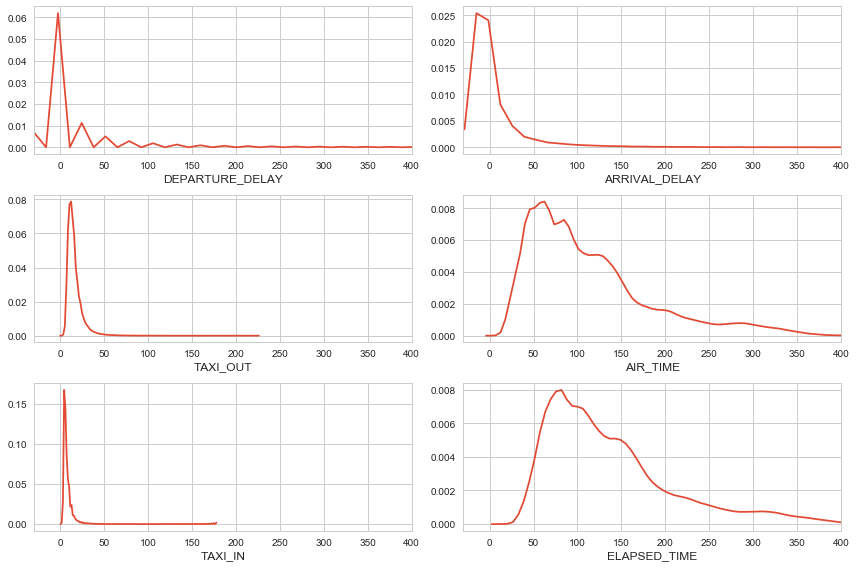

In [467]:
# create figure and axes
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax.flatten()

# loop over each feature names to create distributions
for i, feature in enumerate(features_continuous):
    
    # get row and column index given integer
    row = get_matrix_index(i)[0]
    column = get_matrix_index(i)[1]
    
    sns.distplot(df.loc[(df["CANCELLED"] == False) & (df["DIVERTED"] == False)][feature], ax=ax[row][column], hist=False)
    ax[row][column].set_xlim([-30,400])
    
# use tight layout    
plt.tight_layout()

In [464]:
df.describe()

,MONTH,DAY_OF_WEEK,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,FLIGHT_NUMBER,DEPARTURE_DELAY,ARRIVAL_DELAY,TAXI_OUT,AIR_TIME,...,DIVERTED,CANCELLED,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,CANCELLATION_REASON_INT,ARRIVAL_DELAY_BOOL,DEPARTURE_DELAY_BOOL
count,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06,1.745721e+06,1.745724e+06,1.719832e+06,1.714244e+06,1.718972e+06,1.714244e+06,...,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06,1.745724e+06
mean,6.527119e+00,3.926845e+00,1.329890e+03,1.493567e+03,1.417135e+02,2.175429e+03,9.376968e+00,4.414956e+00,1.607550e+01,1.135346e+02,...,2.569707e-03,1.546293e-02,3.457008e+00,4.308823e+00,5.310994e-01,2.463092e+00,1.481448e-02,3.952071e+00,3.589273e-01,3.654031e-01
std,3.404513e+00,1.988783e+00,4.840828e+02,5.076365e+02,7.524988e+01,1.758617e+03,3.700195e+01,3.921877e+01,8.897315e+00,7.226846e+01,...,5.062712e-02,1.233849e-01,2.181116e+01,2.062883e+01,8.657575e+00,1.298374e+01,1.015504e+00,3.913617e-01,4.796860e-01,4.815432e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.800000e+01,1.000000e+00,-8.200000e+01,-8.000000e+01,1.000000e+00,7.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,2.000000e+00,9.170000e+02,1.110000e+03,8.500000e+01,7.300000e+02,-5.000000e+00,-1.300000e+01,1.100000e+01,6.000000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,7.000000e+00,4.000000e+00,1.325000e+03,1.520000e+03,1.230000e+02,1.690000e+03,-2.000000e+00,-5.000000e+00,1.400000e+01,9.400000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
75%,9.000000e+00,6.000000e+00,1.730000e+03,1.919000e+03,1.740000e+02,3.235000e+03,7.000000e+00,8.000000e+00,1.900000e+01,1.440000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00
max,1.200000e+01,7.000000e+00,2.359000e+03,2.359000e+03,7.180000e+02,9.855000e+03,1.631000e+03,1.638000e+03,2.250000e+02,6.900000e+02,...,1.000000e+00,1.000000e+00,1.631000e+03,1.294000e+03,1.116000e+03,1.101000e+03,5.730000e+02,4.000000e+00,1.000000e+00,1.000000e+00


Observation from continuous features:
- The average arrival departure delay is > 0. 
- Taxi out, taxi in, air time, and elapsed time are nicely distributed.
- The distribution of delay (AIRLINE_DELAY, etc.) aren't very useful as the plots are dominated by non-delayed flights.

This brought me to another question. What's the average delay for those that are delayed?

#### Average Departure and Arrival Delay

In [469]:
df.loc[(df["CANCELLED"] == False) &
       (df["DIVERTED"] == False) &
       (df["ARRIVAL_DELAY"] > 0)][["DEPARTURE_DELAY", "ARRIVAL_DELAY"]].describe()

,DEPARTURE_DELAY,ARRIVAL_DELAY
count,626588.000000,626588.000000
mean,30.287275,33.116838
std,54.444369,52.803449
min,-36.000000,1.000000
25%,0.000000,6.000000
50%,13.000000,15.000000
75%,38.000000,38.000000
max,1631.000000,1638.000000


The above two describes show that:
- For the delayed flights, average arrival delay is ~33 minutes
- For the delayed flights, average departure delay is ~30 minutes

which seems reasonable based on the personal experience.

###  Relation between Flight Delay and Features

Next, I examined the data more carefully, and I tried find any correlation between flight delay/cacellation and other features. Here are some initial speculation on these features:
- Date of depareture: More flights could be delayed on certan time of the year. e.g. holidays.
- Airline: Certain airlines might have more delays than others.
- Flight Number: I would be surprised if delay or cancellation has dependency on a flight number.
- Tail_number: Some aircraft might have more delays than others. e.g. older aircraft might cause more delays than newer aircrafts.
- Origin/Destination Airport: Some airports are known as frequent delay or cancellation. It would be interesting to see if we can quantify this belief.
- Taxi out/in: It is possible that a long taxi in/out causes delay.
- Airtime: Long airtime might also cause more frequent delay.


####  Flight Delay for Airlines

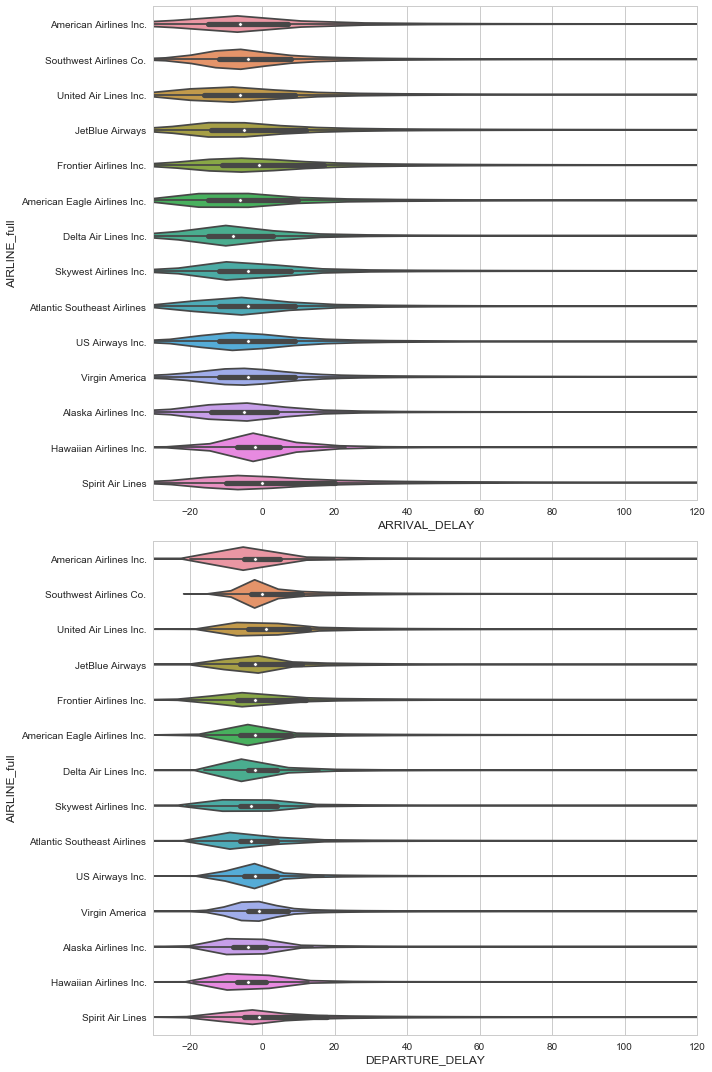

In [43]:
# create figure and axes
fig, ax = plt.subplots(2,1, figsize=(10,15))

sns.violinplot(
        x="ARRIVAL_DELAY",
        y="AIRLINE_full",
        data=df.loc[(df["CANCELLED"] == False) &(df["DIVERTED"] == False)], ax=ax[0])
sns.violinplot(
        x="DEPARTURE_DELAY",
        y="AIRLINE_full",
        data=df.loc[(df["CANCELLED"] == False) &(df["DIVERTED"] == False)], ax=ax[1])

ax[0].set_xlim([-30,120])
ax[1].set_xlim([-30,120])
plt.tight_layout()

####  Average Departure Delay for Delayed Flights

In [44]:
df.groupby("AIRLINE_full")["DEPARTURE_DELAY"].mean().reset_index().sort_values("DEPARTURE_DELAY", ascending=False)

,AIRLINE_full,DEPARTURE_DELAY
10,Spirit Air Lines,15.895255
12,United Air Lines Inc.,14.528256
5,Frontier Airlines Inc.,13.751506
7,JetBlue Airways,11.508218
9,Southwest Airlines Co.,10.526728
2,American Eagle Airlines Inc.,10.193348
1,American Airlines Inc.,8.895231
13,Virgin America,8.865499
3,Atlantic Southeast Airlines,8.680125
8,Skywest Airlines Inc.,7.897144


####  Average Arrival Delay for Delayed Flights

In [45]:
df.groupby("AIRLINE_full")["ARRIVAL_DELAY"].mean().reset_index().sort_values("ARRIVAL_DELAY", ascending=False)

,AIRLINE_full,ARRIVAL_DELAY
10,Spirit Air Lines,14.471849
5,Frontier Airlines Inc.,12.970194
7,JetBlue Airways,6.713174
3,Atlantic Southeast Airlines,6.575611
2,American Eagle Airlines Inc.,6.484849
8,Skywest Airlines Inc.,5.944382
12,United Air Lines Inc.,5.495969
13,Virgin America,4.512566
9,Southwest Airlines Co.,4.276870
11,US Airways Inc.,3.633171


This is very interesting. This violin plot shows the distribution of arrival and departure delay. 
- on average, American Airline, US Airways, Skywest, and Frontier Airline are delayed the most. 
- United has lower average delay, but they have large outliers which means that when a flight is delayed it's more likely to get delayed for a long time.
- Virgin America has very narrow distribution with low average delay.

Now, I investigated delay as a function of airports.

#### Flight Delay in Popular Airports

In [404]:
# select frequent airports
freq_airport_origin = np.array(df.groupby("ORIGIN_AIRPORT").index.count().loc[lambda x: x> 20000].reset_index()["ORIGIN_AIRPORT"])

# create dataframe for frequent airports
df_airport_origin = df.loc[np.array(df["ORIGIN_AIRPORT"].apply(lambda x: x in freq_airport_origin))]

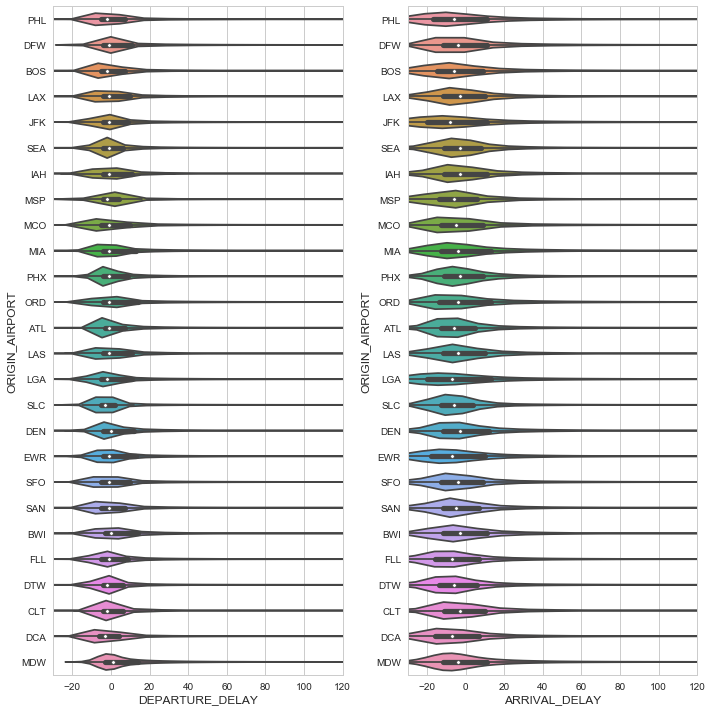

In [408]:
# create figure and axes
fig, ax = plt.subplots(1,2, figsize=(10,10))

# create violin plots for delay vs. airport
sns.violinplot(
        x="DEPARTURE_DELAY",
        y="ORIGIN_AIRPORT",
        data=df_airport_origin, ax=ax[0])
sns.violinplot(
        x="ARRIVAL_DELAY",
        y="ORIGIN_AIRPORT",
        data=df_airport_origin, ax=ax[1])

ax[0].set_xlim([-30,120])
ax[1].set_xlim([-30,120])
plt.tight_layout()

#### Average Flight Delay in Popular Airports

In [470]:
df_airport.groupby("ORIGIN_AIRPORT_full")["DEPARTURE_DELAY"].mean().reset_index().sort_values("DEPARTURE_DELAY", ascending=False).head(5)

,ORIGIN_AIRPORT_full,DEPARTURE_DELAY
3,Chicago O'Hare International Airport,14.124171
17,Newark Liberty International Airport,13.757076
0,Baltimore-Washington International Airport,13.254607
12,LaGuardia Airport (Marine Air Terminal),13.058372
2,Chicago Midway International Airport,12.889489


In [471]:
df_airport.groupby("DESTINATION_AIRPORT_full")["ARRIVAL_DELAY"].mean().reset_index().sort_values("ARRIVAL_DELAY", ascending=False).head(5)

,DESTINATION_AIRPORT_full,ARRIVAL_DELAY
263,St. Cloud Regional Airport,35.260870
250,Sawyer International Airport,20.075000
275,Trenton Mercer Airport,17.968013
13,Aspen-Pitkin County Airport,17.826638
169,Mammoth Yosemite Airport,17.756098


### Delay reasons

Next, I would like to check in the exploratory analysis is to look at the distribution of different causes of delay. In data, there are 4 different causes for delay:
- Airline
- Late aircraft
- Weather
- National air system
- Security

In [49]:
series_delay = np.array([
    df["AIRLINE_DELAY_BOOL"].sum(),
    df["LATE_AIRCRAFT_DELAY_BOOL"].sum(),
    df["WEATHER_DELAY_BOOL"].sum(),
    df["AIR_SYSTEM_DELAY_BOOL"].sum(),
    df["SECURITY_DELAY_BOOL"].sum()
    ])


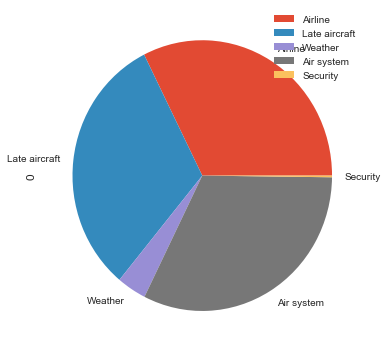

In [472]:
# create figure and axes
fig, ax = plt.subplots(1,1, figsize=(5,5))

# create pie plot
pd.DataFrame(series_delay, index=["Airline",
                           "Late aircraft",
                           "Weather",
                           "Air system",
                           "Security"]).plot.pie(subplots=True, ax = ax)
plt.tight_layout()

The above pie plot shows that the majority of delay is caused by airlines.

### Aircraft tail number and delay
Before closing the exploratory analysis, I wanted to see if delay is more often caused by some aircraft specified by tail number. Here is the results. Because some aircraft only have small number of flights, I only plotted the aircrafts that have more than 10 flights.

In [416]:
np.array(df.groupby("TAIL_NUMBER").index.count().loc[lambda x: x> 800].reset_index()["TAIL_NUMBER"])

19

In [417]:
# select frequent airports
freq_tail_number = np.array(df.groupby("TAIL_NUMBER").index.count().loc[lambda x: x> 800].reset_index()["TAIL_NUMBER"])

# create dataframe for frequent airports
df_freq = df.loc[np.array(df["TAIL_NUMBER"].apply(lambda x: x in freq_tail_number))]

#### Aircraft tail number and delay

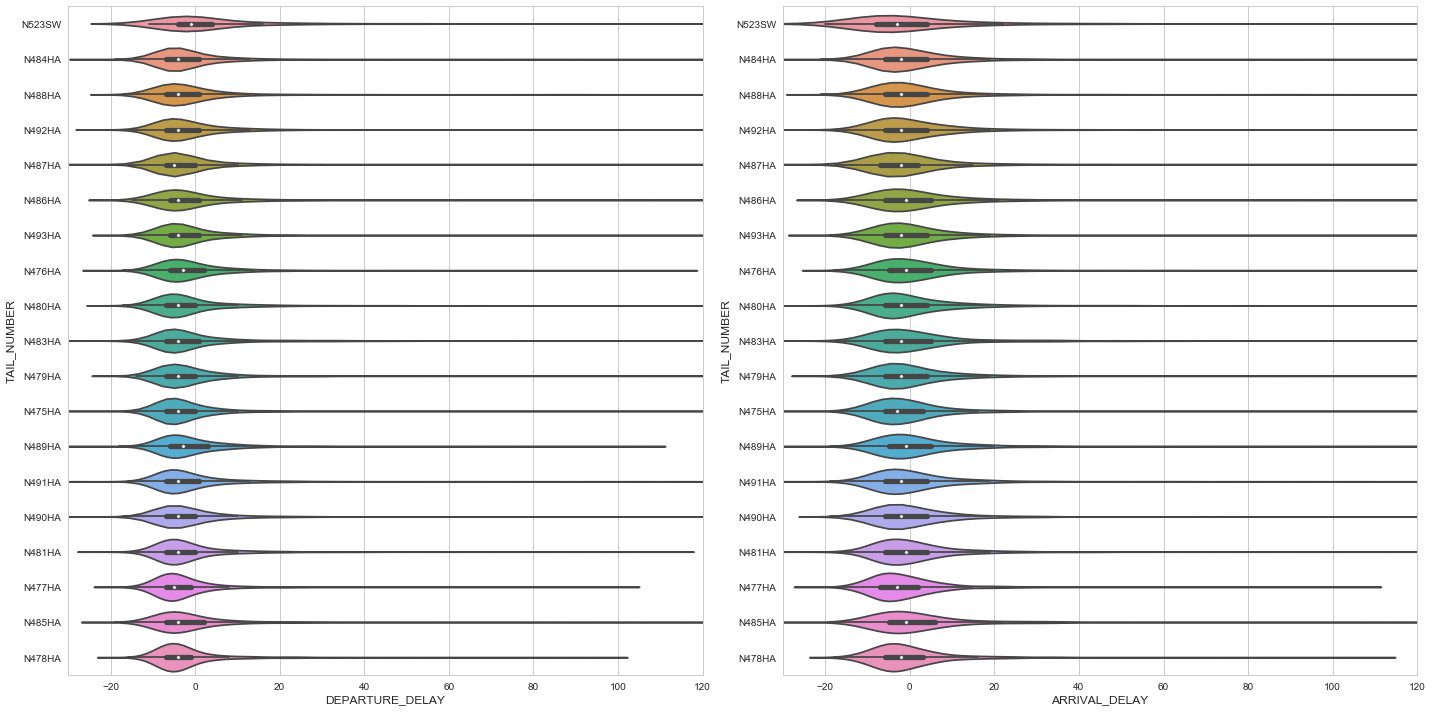

In [420]:
# create figure and axes
fig, ax = plt.subplots(1,2, figsize=(20,10))

# create violin plots for delay vs. airport
sns.violinplot(
        x="DEPARTURE_DELAY",
        y="TAIL_NUMBER",
        data=df_freq, ax=ax[0])
sns.violinplot(
        x="ARRIVAL_DELAY",
        y="TAIL_NUMBER",
        data=df_freq, ax=ax[1])

ax[0].set_xlim([-30,120])
ax[1].set_xlim([-30,120])
plt.tight_layout()

In [52]:
df.groupby("TAIL_NUMBER")["ARRIVAL_DELAY"].mean().reset_index().sort_values("ARRIVAL_DELAY", ascending=False).head(5)

,TAIL_NUMBER,ARRIVAL_DELAY
2984,N670US,317.000000
160,N128UA,274.500000
3652,N79011,254.000000
4075,N851NW,228.000000
3660,N791UA,207.666667


In [53]:
df.groupby("TAIL_NUMBER")["ARRIVAL_DELAY"].mean().reset_index().sort_values("ARRIVAL_DELAY", ascending=True).head(5)

,TAIL_NUMBER,ARRIVAL_DELAY
437,N176DZ,-32.0
3828,N812NW,-28.4
3915,N826MH,-25.0
3903,N824NW,-24.0
3943,N830MH,-23.0


In [54]:
df.loc[:, ["DEPARTURE_DELAY", "ARRIVAL_DELAY"]].describe()

,DEPARTURE_DELAY,ARRIVAL_DELAY
count,1.719702e+06,1.713959e+06
mean,9.376769e+00,4.402372e+00
std,3.719035e+01,3.936483e+01
min,-6.800000e+01,-8.700000e+01
25%,-5.000000e+00,-1.300000e+01
50%,-2.000000e+00,-5.000000e+00
75%,7.000000e+00,8.000000e+00
max,1.649000e+03,1.636000e+03


This is very interesting. Most of the aircrafts have arrival and departure delay around 0, but there are some aircraft that cause delay more often.

### Delay as a function of taxi in, taxi out, air time

Now, I investigated the delays as a function of features. It is possible that flights are more often delayed when taxi in, taxi out times are longer. In order to investigate this, I made scatter plots, feature vs arrival and departure delay.

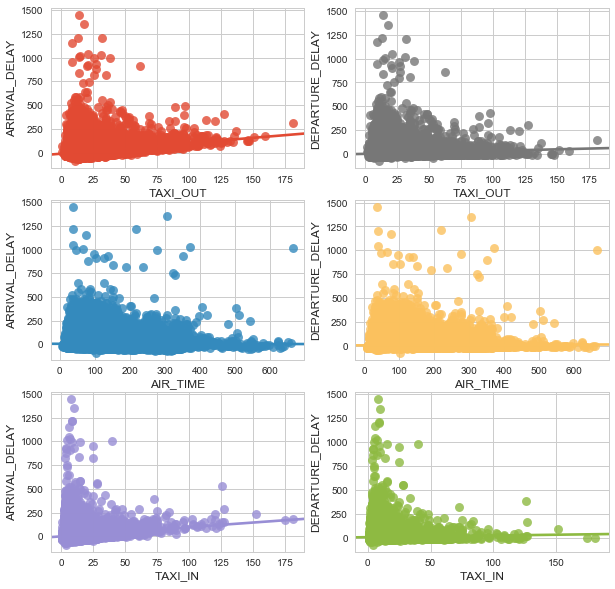

In [55]:
# define features to plot
numeric_features = ["TAXI_OUT","AIR_TIME","TAXI_IN"]

# create figure and axes
fig, ax = plt.subplots(3,2, figsize=(10,10))

for i, feature in enumerate(numeric_features):
    sns.regplot(x=feature, y="ARRIVAL_DELAY", data=df.loc[df["PADDING_TIME"] < 1440], scatter_kws={"s": 80}, ax=ax[i][0])
    
for i, feature in enumerate(numeric_features):
    sns.regplot(x=feature, y="DEPARTURE_DELAY", data=df.loc[df["PADDING_TIME"] < 1440], scatter_kws={"s": 80}, ax=ax[i][1])

The plots show that there are some relation between taxi in, taxi out time and arrival/departure delay as expected. However, the majority of delay occurs when taxi in, taxi out times are still reasonable. This tells us that these features aren't sufficient enough to explain flight delays.

## Random Forest Classifier

###  Features and Label

I can continue to investigate the relation between features and delay, but this would be very time-consuming and tedious process. Instead, I would like to build random forest classification model for each type of delay (Airline, Late air craft, etc.), and I will look at the important features. Then I can re-visit the effect of these important features.

So let's first prepare a datafarme with features.

In [56]:
# Only consider flights that took place
df_not_cancelled = df.loc[(df["CANCELLED"] == False) &(df["DIVERTED"] == False)]

In [57]:
# convert categorical values to integers
le = LabelEncoder()
df_not_cancelled.loc[:,"AIRLINE"] = le.fit_transform(df_not_cancelled["AIRLINE"])
df_not_cancelled.loc[:,"FLIGHT_NUMBER"] = le.fit_transform(df_not_cancelled["FLIGHT_NUMBER"])
df_not_cancelled.loc[:,"ORIGIN_AIRPORT"] = le.fit_transform(df_not_cancelled["ORIGIN_AIRPORT"])
df_not_cancelled.loc[:,"DESTINATION_AIRPORT"] = le.fit_transform(df_not_cancelled["DESTINATION_AIRPORT"])
df_not_cancelled.loc[:,"TAIL_NUMBER"] = le.fit_transform(df_not_cancelled["TAIL_NUMBER"])

In [58]:
# create X
X = df_not_cancelled[[
            "MONTH",
            "DAY_OF_WEEK",
            "AIRLINE",
            "FLIGHT_NUMBER",
            "TAIL_NUMBER",
            "ORIGIN_AIRPORT",
            "DESTINATION_AIRPORT",
            "TAXI_OUT",
            "AIR_TIME",
            "TAXI_IN",
            ]]

y1 = df_not_cancelled[[
        "ARRIVAL_DELAY_BOOL"]]

y2 = df_not_cancelled[[
        "DEPARTURE_DELAY_BOOL"]]

Then we split train and test set. Here, I am preparing two y labels. I am going to build two separate models to predict arrival and departure delay.
- y1 represent True/False of arrival delay
- y2 represent True/False of departure delay

In [59]:
# train/test split
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2)

### Grid Search

Grid search is performed to find the optimum set of parameters for RandomForest. Cross-validation is used to evaluate the performance given a set of parameters, and the parameters that gives the score is chosen. For random forest models, the mean accuracy is used.

However, often GridSearch results in over-fitting, and the parameters are further adjusted to avoid over-fitting the training samples.

In [60]:
# initiate random forest model
model_airline_arrival = RandomForestClassifier()
model_airline_departure = RandomForestClassifier()

# cross-validation fold
n_cross_validation = 5

In [61]:
# flag for grid search
GridSearch = True


if GridSearch:
    # perform GridSearch for RandomForest
    param_grid =    {
                    'n_estimators':[100], 'max_features': [3,5,7],
                    'max_depth': [3,4,5],
                    'min_samples_leaf': [2],
                    'class_weight': ['balanced']
                    }
    
    # initiate grid search
    grid_search_arrival = GridSearchCV( estimator=model_airline_arrival, param_grid=param_grid,
                                cv=n_cross_validation, n_jobs=-1, scoring="f1")
    
    grid_search_departure = GridSearchCV( estimator=model_airline_departure, param_grid=param_grid,
                                cv=n_cross_validation, n_jobs=-1, scoring="f1")
    
    # fit grid search
    grid_search_arrival.fit(X_train, y1_train.values.ravel())
    grid_search_departure.fit(X_train, y2_train.values.ravel())
    
    # best parameters found by GridSearch
    params_arrival = grid_search_arrival.best_params_
    params_departure = grid_search_departure.best_params_
    print(grid_search_arrival.best_params_)
    print(grid_search_departure.best_params_)

{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
{'class_weight': 'balanced', 'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 100}


Then we set model parameters with the hyperparameters obtained from GridSearch.

In [62]:
# set parameters obtained from GridSearch
if GridSearch:
    model_airline_arrival.set_params(**params_arrival)
    model_airline_departure.set_params(**params_departure)

### Learning Curve
In order to evaluate the model with the given hyperparemteres, learning curves are produced by plotting training score and test score at varying sample sizes. Cross-validation is used for evaluating training and test scores, and the mean accuracy is used for evaluation.

In [63]:
# set learning curve step
learning_step = np.linspace(0.1,1.0,10)

# get train size and scores from learning_curve
train_sizes_arrival, train_scores_arrival, test_scores_arrival = learning_curve(
        model_airline_arrival, X_train, y1_train.values.ravel(), cv=n_cross_validation, n_jobs=-1,
        train_sizes=learning_step, random_state=0, scoring="f1")

# get train size and scores from learning_curve
train_sizes_departure, train_scores_departure, test_scores_departure = learning_curve(
        model_airline_departure, X_train, y2_train.values.ravel(), cv=n_cross_validation, n_jobs=-1,
        train_sizes=learning_step, random_state=0, scoring="f1")

In [64]:
# get mean and standard dividation of scores for arrival
train_scores_arrival_mean = np.mean(train_scores_arrival, axis=1)
train_scores_arrival_std = np.std(train_scores_arrival, axis=1)
test_scores_arrival_mean = np.mean(test_scores_arrival, axis=1)
test_scores_arrival_std = np.std(test_scores_arrival, axis=1)

# get mean and standard dividation of scores for departure
train_scores_departure_mean = np.mean(train_scores_departure, axis=1)
train_scores_departure_std = np.std(train_scores_departure, axis=1)
test_scores_departure_mean = np.mean(test_scores_departure, axis=1)
test_scores_departure_std = np.std(test_scores_departure, axis=1)

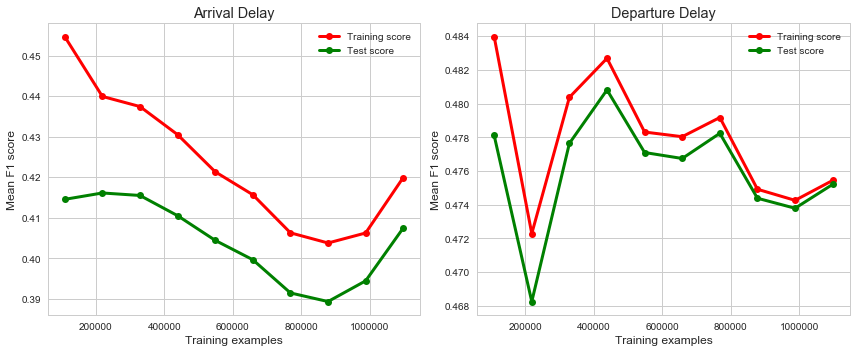

In [65]:
# create axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# plot learning curve for Arrival delay
ax1.plot(train_sizes_arrival, train_scores_arrival_mean, color="r", marker="o", linewidth=3, label="Training score")
ax1.plot(train_sizes_arrival, test_scores_arrival_mean, color="g", marker="o", linewidth=3, label="Test score")

# plot learning curve for Departure delay
ax2.plot(train_sizes_departure, train_scores_departure_mean, color="r", marker="o", linewidth=3, label="Training score")
ax2.plot(train_sizes_departure, test_scores_departure_mean, color="g", marker="o", linewidth=3, label="Test score")

# customize plots
for ax in (ax1, ax2):
    ax.legend()
    #ax.set_ylim([0.5,1])
    ax.set_ylabel("Mean F1 score")
    ax.set_xlabel("Training examples")
    
ax1.set_title("Arrival Delay")
ax2.set_title("Departure Delay")

# save figure
plt.tight_layout()

Here, we are showing the learning curves for two random forest classifier for arrival delay and departure delay. y-axis shows the mean accuracy score of these models. Observations from these plots include:
- The plots show that the training score and the test score converges nicely at larger sample size, indiciating that the models aren't overfitting.
- The fact that the training and the test score converge indicates that obtaining more sample wouldn't help us to build a better model.

### Cross-validation metrics
In addition to learning curves, the performance of estimators are evaluated using cross-validated metrics such as accuracay and F! score. The scores are calculated for two models using 5-fold cross-validation.

In [66]:
# define scoring method
scoring = ["accuracy", "f1"]
n_cross_validation = 5

# obtain cross-validated scores
scores_arrival = cross_validate(model_airline_arrival, X_train, y1_train.values.ravel(), cv=n_cross_validation, scoring=scoring, return_train_score=True)
scores_departure = cross_validate(model_airline_departure, X_train, y2_train.values.ravel(), cv=n_cross_validation, scoring=scoring, return_train_score=True)

#### Cross-validation score

In [67]:
# cross-validated accuracy
print("Arrival delay model")
print("train accuracy = %0.3f (+/- %0.3f)" % (scores_arrival["train_accuracy"].mean(), scores_arrival["train_accuracy"].std()*100))
print("test accuracy = %0.3f (+/- %0.3f)" % (scores_arrival["test_accuracy"].mean(), scores_arrival["test_accuracy"].std()*100))

print("Departure delay model")
print("train accuracy = %0.3f (+/- %0.3f)" % (scores_departure["train_accuracy"].mean(), scores_departure["train_accuracy"].std()*100))
print("test accuracy = %0.3f (+/- %0.3f)" % (scores_departure["test_accuracy"].mean(), scores_departure["test_accuracy"].std()*100))

# cross-validated f1
print("Arrival delay model")
print("train f1 = %0.3f (+/- %0.3f)" % (scores_arrival["train_f1"].mean(), scores_arrival["train_f1"].std()*100))
print("test f1 = %0.3f (+/- %0.3f)" % (scores_arrival["test_f1"].mean(), scores_arrival["test_f1"].std()*100))

print("Departure delay model")
print("train f1 = %0.3f (+/- %0.3f)" % (scores_departure["train_f1"].mean(), scores_departure["train_f1"].std()*100))
print("test f1 = %0.3f (+/- %0.3f)" % (scores_departure["test_f1"].mean(), scores_departure["test_f1"].std()*100))

Arrival delay model
train accuracy = 0.521 (+/- 0.343)
test accuracy = 0.511 (+/- 0.357)
Departure delay model
train accuracy = 0.593 (+/- 0.425)
test accuracy = 0.593 (+/- 0.432)
Arrival delay model
train f1 = 0.420 (+/- 0.478)
test f1 = 0.408 (+/- 0.488)
Departure delay model
train f1 = 0.476 (+/- 0.812)
test f1 = 0.476 (+/- 0.853)


### Fitting Models and Making Prediction

In the previous section, the hyperparameters for two models are chosen by learning curves and cross-validated scores. Now, the models are trained using the training dataset, and predictions are made on training and test datasets.

After making predictions, the performance is evaluated by confusion matrix.

In [68]:
# fit train dataset
model_airline_arrival.fit(X_train,y1_train.values.ravel())
model_airline_departure.fit(X_train,y2_train.values.ravel())

# make prediction for arrival and departure delay
y_pred_test_arrival = model_airline_arrival.predict(X_test)
y_pred_test_departure = model_airline_departure.predict(X_test)

In [69]:
# obtained from sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    plt.title(title)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[118798  98762]
 [ 68443  56789]]
Confusion matrix, without normalization
[[134860  80831]
 [ 60314  66787]]


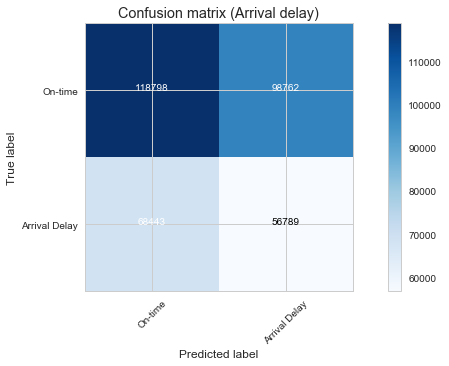

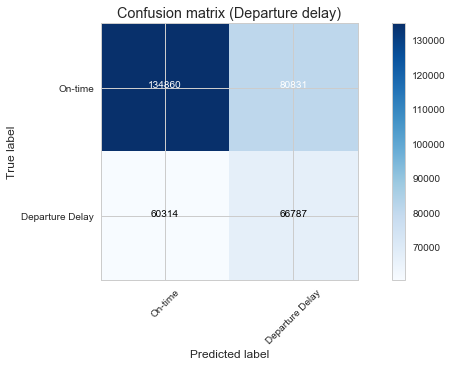

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y1_test, y_pred_test_arrival)
np.set_printoptions(precision=2)
class_names = ["On-time", "Arrival Delay"]

# create figure and axes
fig, ax = plt.subplots(1,1, figsize=(10,5))

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix (Arrival delay)')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y2_test, y_pred_test_departure)
np.set_printoptions(precision=2)
class_names = ["On-time", "Departure Delay"]

# create figure and axes
fig, ax = plt.subplots(1,1, figsize=(10,5))

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix (Departure delay)')

In [71]:
model_airline_arrival.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

### Feature Importance
In random forest classifier, feature importance is calculated by gini imputity. 

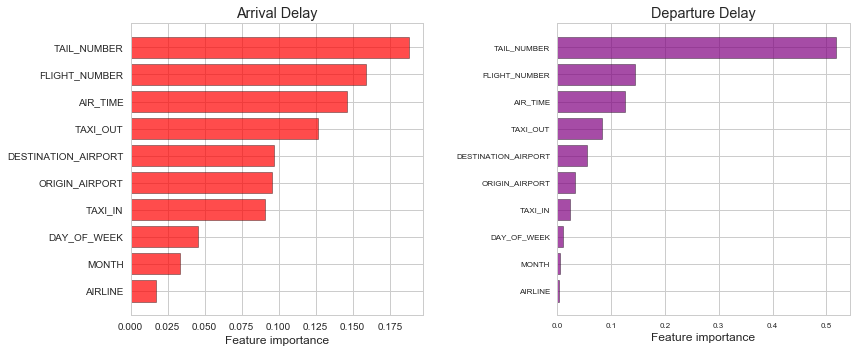

In [72]:
# create figure and axes
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
n_features = 10

# get feature name and feature importance
feature_name = X.columns.values
feature_importance_arrival = model_airline_arrival.feature_importances_
feature_importance_departure = model_airline_departure.feature_importances_

# pick top features
top_features_arrival = sorted(   zip(feature_name, feature_importance_arrival),
                            key=lambda x:x[1], reverse=True)
top_features_departure = sorted(   zip(feature_name, feature_importance_departure),
                            key=lambda x:x[1], reverse=True)

# make horizontal bar plot
ax1.barh(np.arange(n_features), [x[1] for x in top_features_arrival], color="r", alpha=0.7, edgecolor="black")
ax2.barh(np.arange(n_features), [x[1] for x in top_features_departure], color="purple", alpha=0.7, edgecolor="black")

# customize plots
for ax in (ax1, ax2):
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels([x[0] for x in top_features_arrival])
    ax.invert_yaxis()
    ax.set_xlabel("Feature importance")
    
ax1.set_title("Arrival Delay")
ax2.set_title("Departure Delay")

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=8)

## Random Forest with additional Aircraft Data

In [73]:
"YEAR MFR", "MFR MDL CODE", "EXPIRATION DATE"

('YEAR MFR', 'MFR MDL CODE', 'EXPIRATION DATE')

In [74]:
# Only consider flights that took place
df_not_cancelled = df.loc[(df["CANCELLED"] == False) &(df["DIVERTED"] == False)]

In [75]:
# convert categorical values to integers
le = LabelEncoder()
df_not_cancelled.loc[:,"AIRLINE"] = le.fit_transform(df_not_cancelled["AIRLINE"])
df_not_cancelled.loc[:,"FLIGHT_NUMBER"] = le.fit_transform(df_not_cancelled["FLIGHT_NUMBER"])
df_not_cancelled.loc[:,"ORIGIN_AIRPORT"] = le.fit_transform(df_not_cancelled["ORIGIN_AIRPORT"])
df_not_cancelled.loc[:,"DESTINATION_AIRPORT"] = le.fit_transform(df_not_cancelled["DESTINATION_AIRPORT"])
df_not_cancelled.loc[:,"TAIL_NUMBER"] = le.fit_transform(df_not_cancelled["TAIL_NUMBER"])

### Features and label

In [77]:
# create X
X = df_not_cancelled[[
            "MONTH",
            "DAY_OF_WEEK",
            "AIRLINE",
            "FLIGHT_NUMBER",
            "TAIL_NUMBER",
            "ORIGIN_AIRPORT",
            "DESTINATION_AIRPORT",
            "TAXI_OUT",
            "AIR_TIME",
            "TAXI_IN",
            "YEAR MFR",
            "MFR MDL CODE",
            "EXPIRATION DATE",
            "TYPE ENGINE",
            "TYPE AIRCRAFT",
            ]]

y1 = df_not_cancelled[[
        "ARRIVAL_DELAY_BOOL"]]

y2 = df_not_cancelled[[
        "DEPARTURE_DELAY_BOOL"]]

In [78]:
# train/test split
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2)

### Grid Search

In [79]:
# initiate random forest model
model_airline_arrival = RandomForestClassifier()
model_airline_departure = RandomForestClassifier()

# cross-validation fold
n_cross_validation = 5

In [80]:
# flag for grid search
GridSearch = True


if GridSearch:
    # perform GridSearch for RandomForest
    param_grid =    {
                    'n_estimators':[100], 'max_features': [3,4,5],
                    'max_depth': [3,4,5],
                    'min_samples_leaf': [2],
                    'class_weight': ['balanced']
                    }
    
    # initiate grid search
    grid_search_arrival = GridSearchCV( estimator=model_airline_arrival, param_grid=param_grid,
                                cv=n_cross_validation, n_jobs=-1, scoring="f1")
    
    grid_search_departure = GridSearchCV( estimator=model_airline_departure, param_grid=param_grid,
                                cv=n_cross_validation, n_jobs=-1, scoring="f1")
    
    # fit grid search
    grid_search_arrival.fit(X_train, y1_train.values.ravel())
    grid_search_departure.fit(X_train, y2_train.values.ravel())
    
    # best parameters found by GridSearch
    params_arrival = grid_search_arrival.best_params_
    params_departure = grid_search_departure.best_params_
    print(grid_search_arrival.best_params_)
    print(grid_search_departure.best_params_)

{'class_weight': 'balanced', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 100}


In [81]:
# set parameters obtained from GridSearch
if GridSearch:
    model_airline_arrival.set_params(**params_arrival)
    model_airline_departure.set_params(**params_departure)

### Learning Curve

In [82]:
# set learning curve step
learning_step = np.linspace(0.1,1.0,10)

# get train size and scores from learning_curve
train_sizes_arrival, train_scores_arrival, test_scores_arrival = learning_curve(
        model_airline_arrival, X_train, y1_train.values.ravel(), cv=n_cross_validation, n_jobs=-1,
        train_sizes=learning_step, random_state=0, scoring="f1")

# get train size and scores from learning_curve
train_sizes_departure, train_scores_departure, test_scores_departure = learning_curve(
        model_airline_departure, X_train, y2_train.values.ravel(), cv=n_cross_validation, n_jobs=-1,
        train_sizes=learning_step, random_state=0, scoring="f1")

In [83]:
# get mean and standard dividation of scores for arrival
train_scores_arrival_mean = np.mean(train_scores_arrival, axis=1)
train_scores_arrival_std = np.std(train_scores_arrival, axis=1)
test_scores_arrival_mean = np.mean(test_scores_arrival, axis=1)
test_scores_arrival_std = np.std(test_scores_arrival, axis=1)

# get mean and standard dividation of scores for departure
train_scores_departure_mean = np.mean(train_scores_departure, axis=1)
train_scores_departure_std = np.std(train_scores_departure, axis=1)
test_scores_departure_mean = np.mean(test_scores_departure, axis=1)
test_scores_departure_std = np.std(test_scores_departure, axis=1)

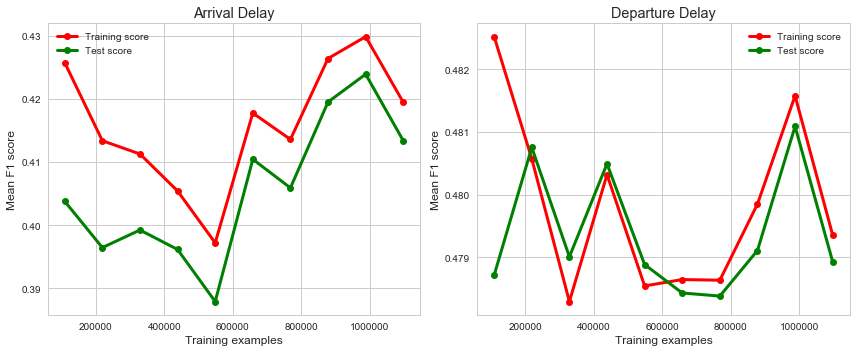

In [84]:
# create axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# plot learning curve for Arrival delay
ax1.plot(train_sizes_arrival, train_scores_arrival_mean, color="r", marker="o", linewidth=3, label="Training score")
ax1.plot(train_sizes_arrival, test_scores_arrival_mean, color="g", marker="o", linewidth=3, label="Test score")

# plot learning curve for Departure delay
ax2.plot(train_sizes_departure, train_scores_departure_mean, color="r", marker="o", linewidth=3, label="Training score")
ax2.plot(train_sizes_departure, test_scores_departure_mean, color="g", marker="o", linewidth=3, label="Test score")

# customize plots
for ax in (ax1, ax2):
    ax.legend()
    #ax.set_ylim([0.5,1])
    ax.set_ylabel("Mean F1 score")
    ax.set_xlabel("Training examples")
    
ax1.set_title("Arrival Delay")
ax2.set_title("Departure Delay")

# save figure
plt.tight_layout()

### Fitting models and making prediction using aircraft data 

In [85]:
# fit train dataset
model_airline_arrival.fit(X_train,y1_train.values.ravel())
model_airline_departure.fit(X_train,y2_train.values.ravel())

# make prediction for arrival and departure delay
y_pred_test_arrival = model_airline_arrival.predict(X_test)
y_pred_test_departure = model_airline_departure.predict(X_test)

Confusion matrix, without normalization
[[119446  98249]
 [ 68494  56603]]
Confusion matrix, without normalization
[[141860  73735]
 [ 63411  63786]]


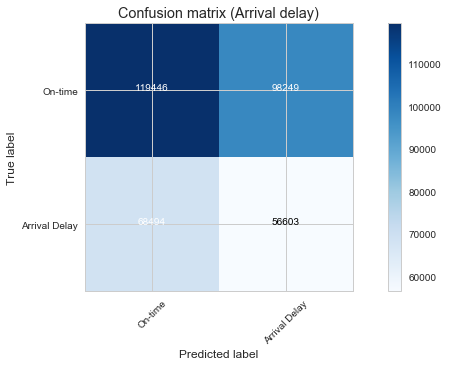

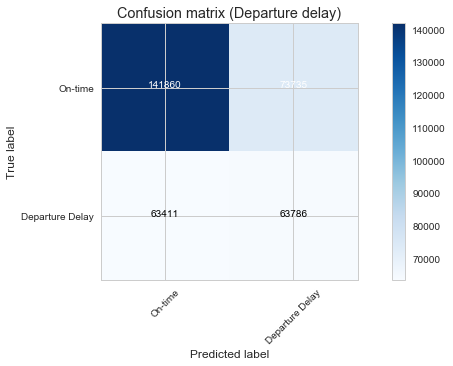

In [86]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y1_test, y_pred_test_arrival)
np.set_printoptions(precision=2)
class_names = ["On-time", "Arrival Delay"]

# create figure and axes
fig, ax = plt.subplots(1,1, figsize=(10,5))

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix (Arrival delay)')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y2_test, y_pred_test_departure)
np.set_printoptions(precision=2)
class_names = ["On-time", "Departure Delay"]

# create figure and axes
fig, ax = plt.subplots(1,1, figsize=(10,5))

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix (Departure delay)')

In [87]:
model_airline_arrival.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

### Feature Importance

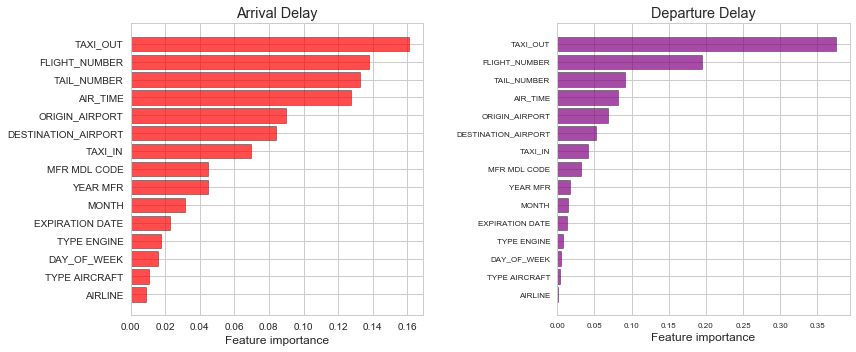

In [88]:
#### create figure and axes
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
n_features = 15

# get feature name and feature importance
feature_name = X.columns.values
feature_importance_arrival = model_airline_arrival.feature_importances_
feature_importance_departure = model_airline_departure.feature_importances_

# pick top features
top_features_arrival = sorted(   zip(feature_name, feature_importance_arrival),
                            key=lambda x:x[1], reverse=True)
top_features_departure = sorted(   zip(feature_name, feature_importance_departure),
                            key=lambda x:x[1], reverse=True)

# make horizontal bar plot
ax1.barh(np.arange(n_features), [x[1] for x in top_features_arrival], color="r", alpha=0.7, edgecolor="black")
ax2.barh(np.arange(n_features), [x[1] for x in top_features_departure], color="purple", alpha=0.7, edgecolor="black")

# customize plots
for ax in (ax1, ax2):
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels([x[0] for x in top_features_arrival])
    ax.invert_yaxis()
    ax.set_xlabel("Feature importance")
    
ax1.set_title("Arrival Delay")
ax2.set_title("Departure Delay")

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=8)

## Interpretation for American Airline

The goal of this project was to identify potential causes of flight delay for American Airline. The feature importance from random forest model suggests that flight delays are related to 
- Taxi out
- Flight number
- Air time
- Origin and destination airports

This result makes sense, and it is somewhat expected as longer taxi in, taxi out time would cause flight dela, and we expact certain airpots to be more busy and have more frequent flight delays than smaller airports. However, the results also suggest that there are more non-trivial factors that play in flight delay, such as
- Tail number
- Aircraft model
- Aircraft manufactured year


### Major reasons for flight delay
- Tail number
- Aircraft model
- Aircraft manufactured year

In [176]:
df_aa = df.loc[(df["CANCELLED"] == False) & (df["DIVERTED"] == False) & (df["AIRLINE"] == "AA")]

In [422]:
# select frequent tail numbers
frequent_tail_number = np.array(df_aa.groupby("TAIL_NUMBER").index.count().loc[lambda x: x> 100].reset_index()["TAIL_NUMBER"])

# frequent flights from American Airline
df_aa_freq = df_aa.loc[df_aa["TAIL_NUMBER"].apply(lambda x: x in frequent_tail_number)]

#### Flight Delay vs Tail Number, Aircraft Model

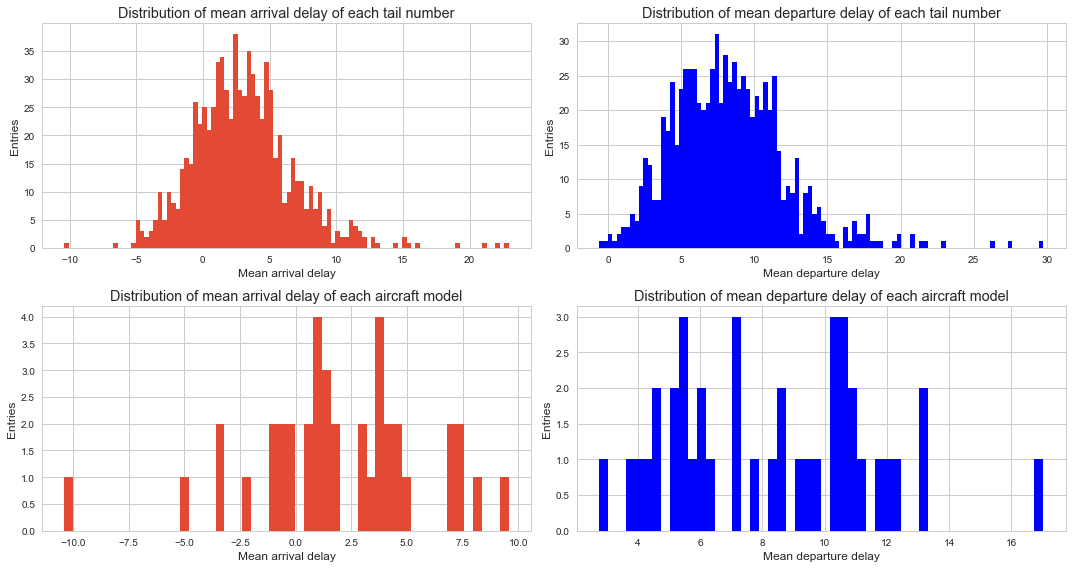

In [423]:
# create figure and axes
fig, ax = plt.subplots(2,2, figsize=(15,8))

df_aa_freq.groupby("TAIL_NUMBER")["ARRIVAL_DELAY"].mean().hist(ax=ax[0,0], bins=100)
df_aa_freq.groupby("TAIL_NUMBER")["DEPARTURE_DELAY"].mean().hist(ax=ax[0,1], bins=100, color='b')

df_aa_freq.groupby("MFR MDL CODE")["ARRIVAL_DELAY"].mean().hist(ax=ax[1,0], bins=50)
df_aa_freq.groupby("MFR MDL CODE")["DEPARTURE_DELAY"].mean().hist(ax=ax[1,1], bins=50, color='b')

ax[0,0].set_xlabel("Mean arrival delay")
ax[0,0].set_ylabel("Entries")
ax[0,0].set_title("Distribution of mean arrival delay of each tail number")

ax[0,1].set_xlabel("Mean departure delay")
ax[0,1].set_ylabel("Entries")
ax[0,1].set_title("Distribution of mean departure delay of each tail number")

ax[1,0].set_xlabel("Mean arrival delay")
ax[1,0].set_ylabel("Entries")
ax[1,0].set_title("Distribution of mean arrival delay of each aircraft model")

ax[1,1].set_xlabel("Mean departure delay")
ax[1,1].set_ylabel("Entries")
ax[1,1].set_title("Distribution of mean departure delay of each aircraft model")


plt.tight_layout()

#### Flight Delay vs Aircraft Manufactured Year

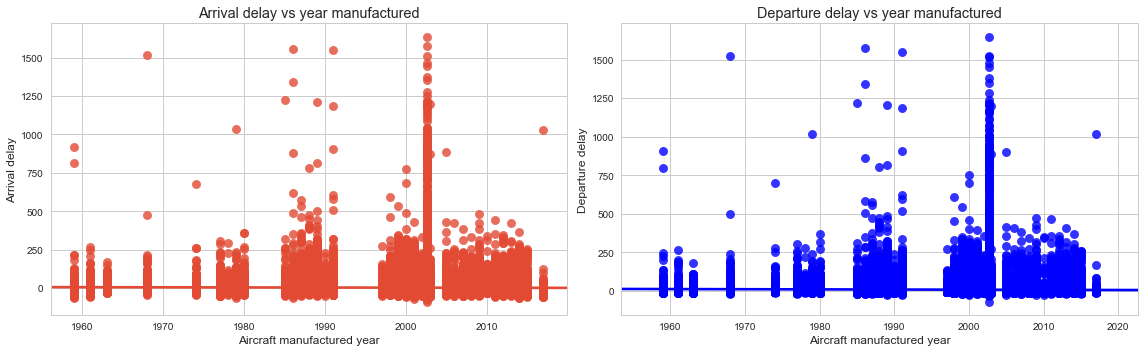

In [424]:
# create figure and axes
fig, ax = plt.subplots(1,2, figsize=(16, 5))

sns.regplot(x="YEAR MFR", y="ARRIVAL_DELAY", data=df_aa_freq, scatter_kws={"s": 80}, ax=ax[0])
sns.regplot(x="YEAR MFR", y="DEPARTURE_DELAY", data=df_aa_freq, scatter_kws={"s": 80}, ax=ax[1], color='b')

ax[0].set_xlabel("Aircraft manufactured year")
ax[0].set_ylabel("Arrival delay")
ax[0].set_title("Arrival delay vs year manufactured")

ax[1].set_xlabel("Aircraft manufactured year")
ax[1].set_ylabel("Departure delay")
ax[1].set_title("Departure delay vs year manufactured")

plt.tight_layout()

Here are some observation from the above plots:
- The distribution of arrival and departure delay for each tail number isn't normally distributed, but it has skewed tails, suggesting that there are some aircrafts that cause flight delay more often than others.
- Arrival and departure delay as a function of aircraft manufactured year suggest that the aircrafts manufactured in particular years (late 1980 to early 1990) cause more frequent flight delays.

### Public Perception on American Airline
In order to understand the public perception on American Airline in comparison to the competitors, the dataset containing customer's sentiment on airlines is obtained from
 https://www.kaggle.com/crowdflower/twitter-airline-sentiment. This dataset contains user sentiment and their reason for the sentiment is obtained from Twitter using NLP. The details can be found in the Kaggle webpage. 

First, I examined general public sentiments on major US airlines. The plot below shows that our client, American Airline received third most negative comments from customers, following US Airways and United.

In [425]:
df_s = pd.read_csv("twitter-airline-sentiment/Tweets.csv")

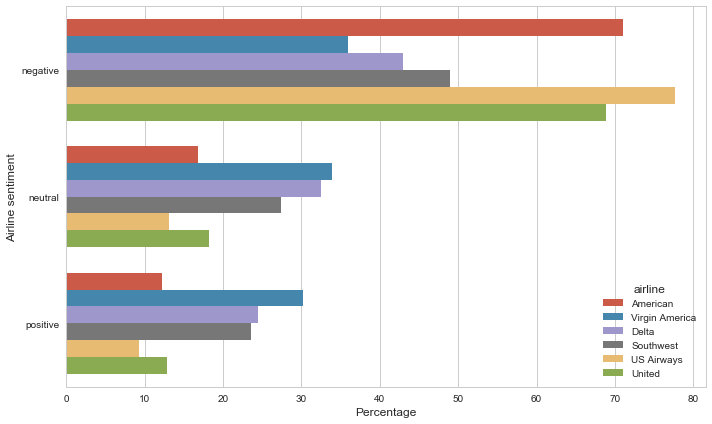

In [426]:
# retrieve negative reason counts
airline_sentiment_counts = (df_s.groupby(['airline'])['airline_sentiment']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('airline_sentiment'))

# create figure and axes
fig, ax = plt.subplots(1,1, figsize=(10,6))

# plot sentiment count
sns.barplot(y="airline_sentiment", x="percentage", hue="airline", data=airline_sentiment_counts)

ax.set_ylabel("Airline sentiment")
ax.set_xlabel("Percentage")
plt.tight_layout()

#### Reasons for Negative Perception

In order to understand the reason for negative sentiment, I examined the data and plotted for the reasons. The plot below shows the results for 6 major US airlines. Here are some observations:

- The majority of negative comments for American Airline comes from customer service issue
- The percentage of the complains on late or bad flight is lower than other airlines

This suggests that unlike the original speculation, American Airline's public perception isn't affected very negatively by canceled or delayed flight in comparison to other major airlines.

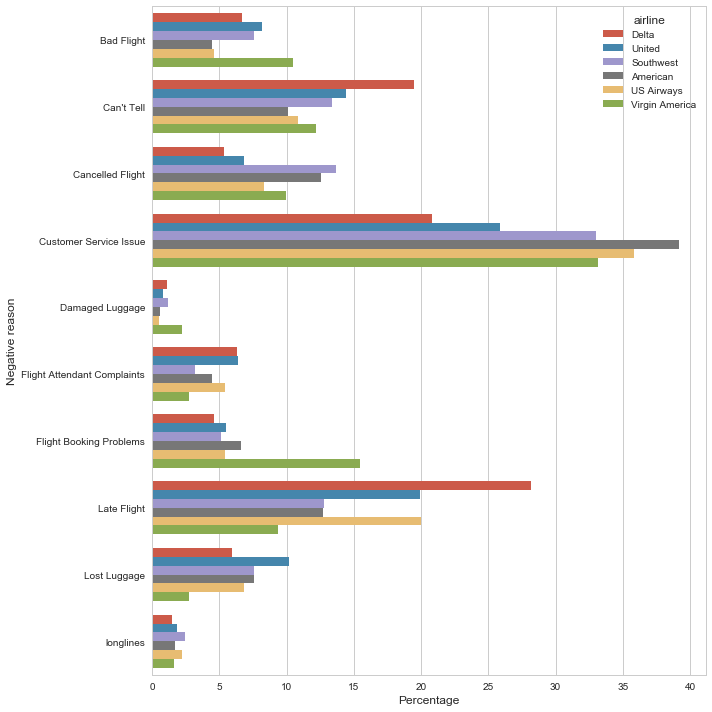

In [427]:
# retrieve negative reason counts
negativereason_counts = (df_s.groupby(['airline'])['negativereason']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('negativereason'))

# create figure and axes
fig, ax = plt.subplots(1,1, figsize=(10,10))

# plot sentiment count
#sns.barplot(y="negativereason", x="percentage", hue="airline", data=negativereason_counts)
sns.barplot(y="negativereason", x="percentage", hue="airline", data=negativereason_counts)

ax.set_ylabel("Negative reason")
ax.set_xlabel("Percentage")
plt.tight_layout()

##  Conclusion

In this project, we examined Air Travel Consumer Report in order to identify possible causes of flight delays and understand the public perception on the client, American Airline.

Exploratory analysis is performed, and the results suggest that our client, American Airline has lower average flight delays in comparison to other major airlines.
- ranked 8th among 14 major airlines in departure delay
- ranked 4th among 14 major airlines in arrival delay

But the exploratory analysis also confirms that flight delays depend on many factors such as airport, taxi in, taxi out, etc. In ordert to identify and quantify important features in predicting flight delay, random forest model is built, suggesting that flight delay also depends on aircraft model and built year. There are other factors that affect flight delay such as flight number and airports, but these factors aren't something American Airline can improve as busy airports and flight numbers will always busy.

In addition, public perception on American Airline is studied using twitter sentiment analysis data, and it suggests that American Airline received third most negative comments from customers, following US Airways and United. However, the majority of negative comments for American Airline comes from customer service issue rather than flight delay.

Based on this study, I suggest American Airline to:
- further investigate the aircrafts that might cause more frequent flight delay and explore the possibility replace them with more reliable aircrafts.
- seek to improve their customer service as the majority of negative comments come from customer service.






